# Predicting the Forum of origin for text data 

---

This notebook shows how to pull [Reddit](https://reddit.com/) 
posts using [PRAW](https://praw.readthedocs.io/en/latest/) and

train a language model that can predict the forum a post originates from.

The method used here is called **Latent Semantic Analysis**

In [1]:
"""
All parameters are kept in the parameters.py file

This is to keep the code clean and provide an
easy to follow, top-level view of this task

"""
from parameters import *

## Build pipeline
The pipeline for this machine learning task is as follows
- Load data using API
- Split training/validation sets
- Text preprocessing/feature extraction
- Select models that fit our use case 
- Train and evaluate each model 

### Load data

- Acquire text data from each forum 
- Filter posts with less than 100 alphabetic characters

In [2]:
import config
import numpy as np
import praw
import re



# List of subreddits to use as a basis for our model
forums = [
    'astrology',
    'datascience',
    'machinelearning',
    'conspiracy',
    'physics'
]


def load_data(forums):
    
    # Create reddit object
    reddit = praw.Reddit(
        client_id = config.id,
        client_secret = config.secret,
        user_agent = 'Reddit Scraper'
    )

    # Count number of alphabetic characters using RegEx substitution
    char_count = lambda post: len(re.sub('\W|\d', '', post.selftext))

    # Condition for filtering the posts
    mask = lambda post: char_count(post) >= 100

    # Lists to hold results
    data = []
    labels = []

    for i, forum in enumerate(forums):

        # Get latest posts from the subreddit
        subreddit_data = reddit.subreddit(forum).new(limit=1000)

        # Filter out posts not satisfying condition
        posts = [post.selftext for post in filter(mask, subreddit_data)]

        # Add posts and labels to respective lists
        data.extend(posts)
        labels.extend([i] * len(posts))

        # Display sample text
        print(f"Number of posts from r/{forum}: {len(posts)}",
              f"\nSample Post: {posts[0][:240]}...\n", "_" * 80 + '\n')
    
    return data, labels


data, labels = load_data(forums)

Number of posts from r/astrology: 571 
Sample Post: Curious what everyones stories are about finding astrology and realizing that there was some kind of wacky higher truth happening here?...
 ________________________________________________________________________________

Number of posts from r/datascience: 618 
Sample Post: Not sure if this is the wrong place to look or not, but I figured I'd ask a group of people that have plenty of experience with finding specific data that they need: I have a scraping project that requires I have the population of each US s...
 ________________________________________________________________________________

Number of posts from r/machinelearning: 843 
Sample Post: Think many on here would find the recent paper [A narrowing of AI research?](https://arxiv.org/abs/2009.10385) interesting. Some of it is not so surprising, but Figure 13 showing many top universities being as narrow as top companies (e.g. ...
 __________________________________________

### Partition training and validation data
Partition training and validation data Hold out some portion 
of our data in order to evaluate how our model performs on unseen text.

It is important to do this **as early as possible**
if you want to accurately measure your model's performance

The following parameters allow for our results to be reproduced

- TEST_SIZE: 
    percentage of total data to be held out from training set
    in order to validate our model's performance on unseen data

- RANDOM_STATE:
    an integer corresponding to the random state of our 
    train_test_split function, and can be used to 
    reproduce the data partitions if needed 


In [3]:
from sklearn.model_selection import train_test_split



def split_data(data, labels, kwargs):

    # Partition training/validation sets
    X_train, X_test, y_train, y_test = train_test_split(
        data, labels, **kwargs)

    print(f"{len(y_test)} samples selected for validation.")
    
    return X_train, X_test, y_train, y_test


# Partition train/test sets
X_train, X_test, y_train, y_test = split_data(
    data, labels, partition_params)

515 samples selected for validation.


### Preprocessing and feature extraction 

- Remove symbols, numbers, and url-like strings with custom preprocessor 
- vectorize text using term frequency-inverse document frequency
- reduce to principal values using singular value decomposition
- Partition data and labels into training/validation sets

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD


def get_pipeline(class_kwargs):
    
    # Vectorization and Singular Value Decomposition objects
    classes = [
        TfidfVectorizer,
        TruncatedSVD,
    ]

    # List of classes to be passed to our Pipeline object
    pipeline = [(Class.__name__, Class(**kwargs))
                for Class, kwargs in zip(classes, class_kwargs)]

    return pipeline


# Get for data cleaning/embedding
pipeline = get_pipeline(embedding_params)

### Model selection

Chose a model or set of models that fit your use case.

Here, we've selected two classification models

- RandomForestClassifier, 
- and LogisticRegressionCV

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV



def define_models(model_kwargs):

    # Model base classes
    classes = [
        RandomForestClassifier,
        LogisticRegressionCV
    ]
    
    # List of model names and instances
    models = [(model.__name__, model(**params), params) 
              for model, params in zip(classes, model_kwargs)]
     
    return models


# List of models (with model names)
models = define_models(model_params)

### Model fitting and evaluation

Fit each model to training data and predict on test set 

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.exceptions import ConvergenceWarning
import warnings

# Ignore convergence warnings
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)



def fit_and_evaluate(models, preprocess, X_train, X_test, y_train, y_test):
    
    results = []
    
    for name, model, params in models:

        # Pipeline to ensure no information leaks from test into model
        pipe = Pipeline(preprocess + [(name, model)])

        # Fit model to training data
        print(f"Fitting {name} to training data...")
        pipe.fit(X_train, y_train)

        # Predict labels for test set
        print("Predicting on validation set")
        y_pred = pipe.predict(X_test)

        results.append({
            'model': name,
            'params': params,
            'predictions': y_pred,
        })

    return results

# Prediction Results
results = fit_and_evaluate(models, pipeline,
                           X_train, X_test, 
                           y_train, y_test)

print("Success")

Fitting RandomForestClassifier to training data...
Predicting on validation set
Fitting LogisticRegressionCV to training data...
Predicting on validation set
Success


## Analyze Results

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

### Counts by post

Examine the number of samples collected from each forum

#### Function

In [9]:
def plot_counts_by_post():
    _, counts = np.unique(labels, return_counts=True)
    data = [(f,c) for f,c in sorted(zip(forums,counts), 
                                    key=lambda x:x[-1],
                                    reverse=True)]
    N = len(data)
    plt.figure(figsize=(2 * N - 1, N // 2), dpi=120)
    plt.title("Number of posts by forum")
    ax = sns.barplot(x=[forum for forum,_ in data],
                     y=[count for _,count in data],
                     palette="plasma")
    plt.legend([' '.join([f.title(),f"- {c} posts"]) 
                for f,c in zip(forums, counts)],
               fontsize=8)
    plt.savefig("images/post_counts.png")
    plt.show()

#### Visual

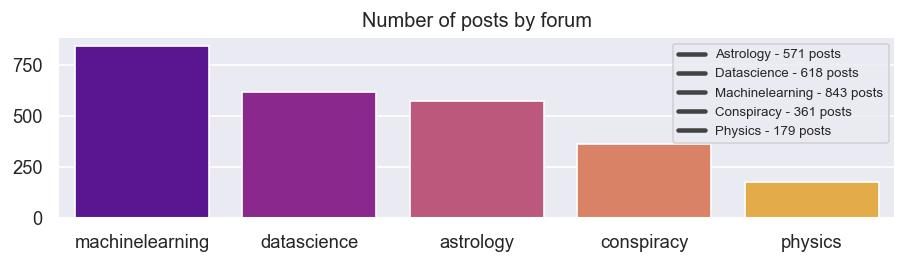

In [10]:
plot_counts_by_post()

### Confusion Matrices

A quick way to visualize the predictions is to use a *confusion matrix*: 
$\mathbf{C}$

Where $\mathbf{C}_{i,j}$ is the number of times
our model predicted $j$ for class $i$

We normalize this matrix feature-wise to get
the percentage of correct predictions

#### Function

In [11]:
def plot_confusion(result):
    name = result['model']
    y_pred = result['predictions']
    C = confusion_matrix(y_test,y_pred)
    C_norm = C.astype('float') / C.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(9,8), dpi=100)
    plt.title(name + " Classification Results")
    plt.xlabel("Ground truth")
    plt.ylabel("Model prediction")
    ticklabels = [f"r/{sub}" for sub in forums]
    ax = sns.heatmap(data=C_norm, 
                     xticklabels=ticklabels,
                     yticklabels=ticklabels,
                     annot=True, fmt='.2f',
                     cmap="Blues")
    for xtick,ytick in zip(ax.get_xticklabels(),ax.get_yticklabels()):
        xtick.set_rotation(45)
        ytick.set_rotation(-45)
    plt.savefig(f"images/confusion_matrix_{name}.png")
    plt.show()

#### Visual

Forrest results


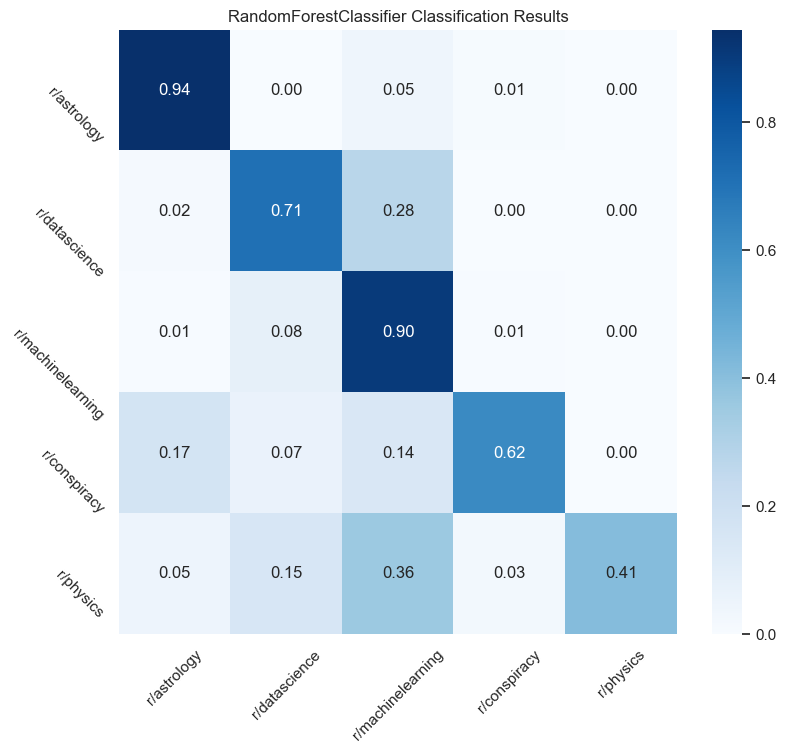

In [12]:
print("Forrest results")
plot_confusion(results[0])

Regression results


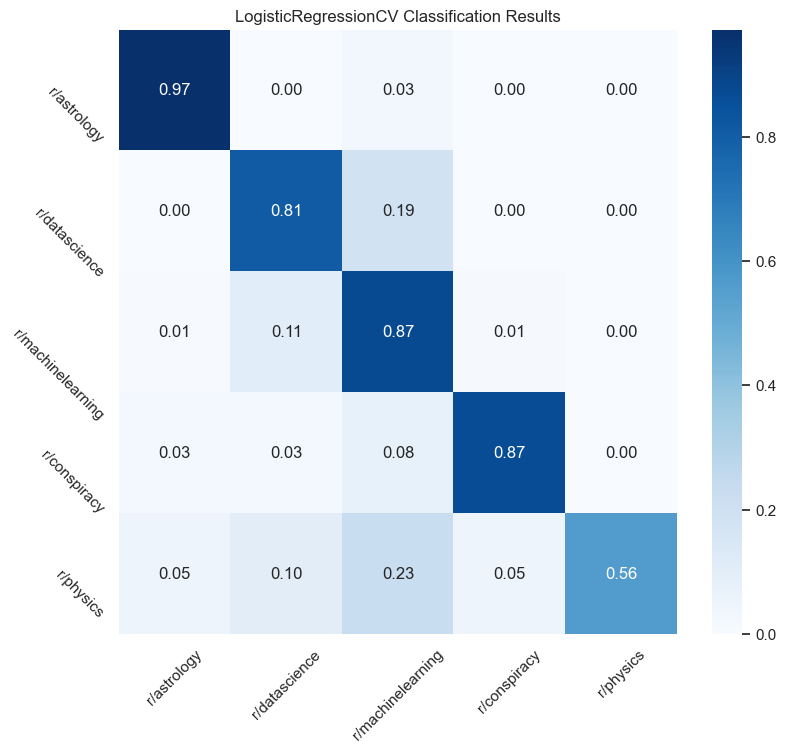

In [13]:
print("Regression results")
plot_confusion(results[-1])